[Источник данных](https://ods.ai/competitions/x5-retailhero-uplift-modeling/data)

# Импорт средств

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklift.models import ClassTransformation, TwoModels
from lightgbm import LGBMClassifier, plot_importance
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, uplift_by_percentile
from sklift.viz import plot_qini_curve, plot_uplift_curve 

# Импорт основных файлов (обработка дат, назначение индексов)

## Импорт информации о заказах: код клиента, заказа, продукта, стоимость продукта, сумма заказа, операции с баллами
Важно: каждая строка полученого датафрейма -- не информация об одном заказе, а информация о каждом отдельном продукте в чеке (в одном заказе может присутствовать несколько продуктов). Столбца с уникальным индексом в датафрейме нет

In [2]:
df_purchases = pd.read_csv('purchases.csv',
                        index_col='client_id',
                        parse_dates=['transaction_datetime'])
df_purchases.head()

,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
client_id,,,,,,,,,,,,
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


## Импорт информации о клиентах: код, пол, возраст, дата регистрации, дата совершения первого заказа (если тот был совершен)
Важно: пол клиента может быть не указан (значение колонки gender "U")

In [3]:
df_clients = pd.read_csv('clients.csv',
                        index_col='client_id',
                        parse_dates=['first_issue_date', 'first_redeem_date'])
df_clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaT,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


## Информация о продуктах: код продукта, код бренда, масса, является ли продукцией сети или алкоголем
Для полей level_1, level_2, level_3, level_4 и segment_id пояснений найдено не было

In [4]:
df_products = pd.read_csv('products.csv', index_col='product_id')
df_products.head()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
product_id,,,,,,,,,,
0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


## Данные, предоставленные для обучения модели: код клиента, информация о том, было ли произведено взаимодействие с ним, совершил ли он целевое действие

In [5]:
df_train = pd.read_csv('uplift_train.csv', index_col='client_id')
df_train.head(10)

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1
000220a0a7,0,1
00022fd34f,1,1
0002ce2217,0,1
00031cbbe6,0,1


Более подробная информация о экспериментальной группе представлена ниже

# Общая информация о данных

## Информация о заказах

In [6]:
print("Размер датасета:", df_purchases.shape)
print("Количество заказов:", df_purchases['transaction_id'].nunique())
print("Количество клиентов, совершавших заказы:", df_purchases.index.nunique())

Размер датасета: (45786568, 12)
Количество заказов: 8045201
Количество клиентов, совершавших заказы: 400162


Обработка NaN-значений предусмотрена не во всех инструментах обработки больших данных. В некоторых случаях от таких значений можно избавиться

In [7]:
df_purchases.isna().any()

transaction_id             False
transaction_datetime       False
regular_points_received    False
express_points_received    False
regular_points_spent       False
express_points_spent       False
purchase_sum               False
store_id                   False
product_id                 False
product_quantity           False
trn_sum_from_iss           False
trn_sum_from_red            True
dtype: bool

trn_sum_from_red -- одно из значений возвращенных баллов. Я предположила, что пустые значения в данном случае можно заменить на 0

In [8]:
df_purchases.fillna(0, inplace=True)

## Информация о клиентах

In [9]:
print('Размер датасета:', n_lines := df_clients.shape)
print('Количество клиентов с уникальными индексами:', n_unique := df_clients.index.nunique())
if (n_lines[0] == n_unique):
    print("В файле нет дублирующих строк")
else:
    print("Что-то пошло не так: сууществуют клиенты с одинаковыми уникальными идентификаторами")

Размер датасета: (400162, 4)
Количество клиентов с уникальными индексами: 400162
В файле нет дублирующих строк


Рассмотрим информацию о клиентах

In [10]:
df_clients.describe()

,first_issue_date,first_redeem_date,age
count,400162,364693,400162.000000
mean,2018-01-09 17:27:24.852597504,2018-06-26 09:51:18.686155008,46.488112
min,2017-04-04 18:24:18,2017-04-11 09:42:20,-7491.000000
25%,2017-07-21 19:54:26.249999872,2017-12-24 15:13:52,34.000000
50%,2017-11-16 15:11:29.500000,2018-06-06 21:02:25,45.000000
75%,2018-06-20 18:09:34,2019-01-04 18:49:48,59.000000
max,2019-03-15 21:50:56,2019-11-20 01:14:10,1901.000000
std,NaN,NaN,43.871218


Программа не позволяет регистрироваться в ней лицам младше 18 лет, слишком большие значения поля возраста также кажутся неправдоподобыми. **Можно видеть совершенно невозможные максимальные и минимальные значения для поля возраста. Выставим корректный интервал от 18 до 100 лет, включая границы**

In [11]:
print('Клиентов с некорректным возрастом:',
      count_incorrect := df_clients[(df_clients['age'] < 18) | (df_clients['age'] > 100)]['age'].count())
print(f'В процентах от выборки: {count_incorrect/df_clients.shape[0]:.2%}')

Клиентов с некорректным возрастом: 6601
В процентах от выборки: 1.65%


**Как можно видеть, выбросов немного (меньше 2%), их можно будет исключить при построении модели.** Построим диаграмму распределения по возрасту по корректным значениям

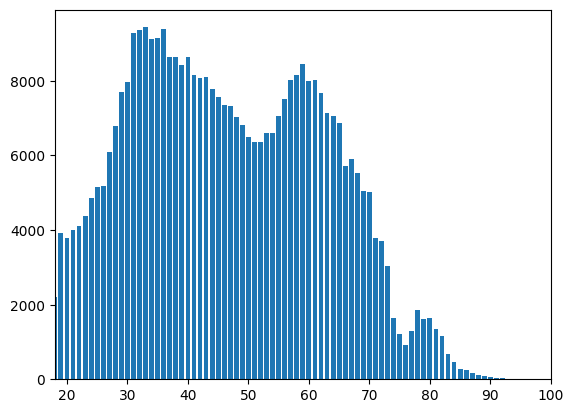

In [12]:
age_figure, age_axes = plt.subplots()
x = sorted(set(df_clients['age']))
all_ages = list(df_clients['age'])
y = list([all_ages.count(i) for i in x])
age_axes.set_xlim(18, 100);
age_axes.bar(x, y)
plt.show()

В поле "Пол" отклонений не наблюдается: возможны всего три значения. Отобразим их на диаграмме (записи с аномалиями возраста включены в выборку)

In [13]:
set(df_clients['gender'].values)

{'F', 'M', 'U'}

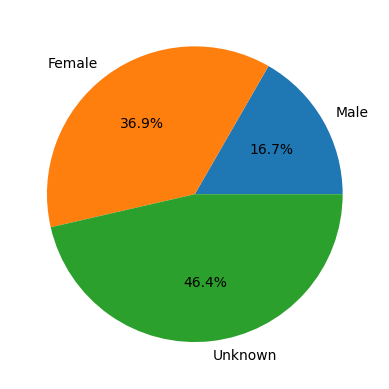

In [14]:
gender_figure, gender_axes = plt.subplots()
gender_labels = ['Male', 'Female','Unknown']
gender_sizes = [
    df_clients[df_clients.gender == 'M']['gender'].count(),
    df_clients[df_clients.gender == 'F']['gender'].count(),
    df_clients[df_clients.gender == 'U']['gender'].count()
]
gender_axes.pie(gender_sizes, labels=gender_labels, autopct='%1.1f%%')
plt.show()

Отобразим даты регистрации и первой покупки. У некоторых покупателей первая дата заказа не отображена в наборе данных (причем их количество значительно), но ее можно восстановить по датасету с заказами

In [15]:
df_clients.isna().sum()

first_issue_date         0
first_redeem_date    35469
age                      0
gender                   0
dtype: int64

In [16]:
issue_dates_list = list([i.date() for i in df_clients['first_issue_date']])
x = sorted(set(issue_dates_list))
y = [issue_dates_list.count(i) for i in x]

In [17]:
# i == i - проверка на NaN
redeem_dates_list = list([i.date() for i in df_clients['first_redeem_date'] if i == i])
x2 = sorted(set(redeem_dates_list))
y2 = [redeem_dates_list.count(i) for i in x2]

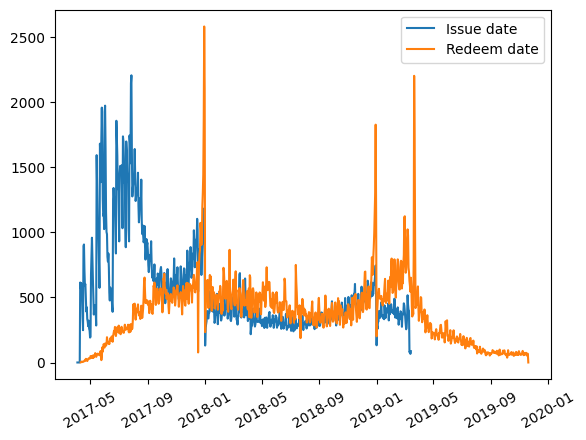

In [18]:
fig, ax = plt.subplots()
ax.plot(x, y, label='Issue date')
ax.plot(x2, y2, label='Redeem date')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30)
plt.show()

Видно, что даты первых заказов образууют пики. Даты первых 10 пиков первых заказов после регистрации:

In [19]:
[print(i + 1, x2[y2.index(sorted(y2, reverse=True)[i])]) for i in range(10)]

1 2017-12-30
2 2019-03-22
3 2017-12-31
4 2017-12-29
5 2018-12-30
6 2019-03-23
7 2017-12-28
8 2018-12-29
9 2017-12-27
10 2017-12-26


[None, None, None, None, None, None, None, None, None, None]

Большая часть пиков -- предновогодние даты. Происхождение "мартовского" пика неизвестно

**Интересная закономерность: в некоторых случаях первый заказ совершен чуть раньше регистрации**

In [20]:
df_clients[df_clients['first_redeem_date'] < df_clients['first_issue_date']]

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
01440dcc9f,2018-11-09 13:50:09,2018-09-27 17:35:20,37,U
018d71e6aa,2019-02-16 08:42:25,2019-02-16 08:42:24,25,U
0251efe59c,2018-12-30 13:03:21,2018-12-30 13:03:12,32,U
02fa1ab71b,2018-11-29 14:04:36,2018-11-29 14:04:26,71,U
0319f9b99b,2018-11-19 12:52:08,2018-11-19 12:51:05,46,M
...,...,...,...,...
fe405531e6,2019-01-16 17:13:01,2019-01-16 17:12:59,60,U
fe73f09f21,2019-03-08 11:36:08,2019-03-08 11:35:52,51,F
ff4bb495cf,2018-12-21 10:41:25,2018-12-21 10:40:52,32,F


**Временная разница между первым заказом и регистрацией в таком случае не превышает минуты. Можно предположить, что эти клиенты были автоматически зарегистрированы в процессе совершения первого заказа.**

In [21]:
df_clients[df_clients['first_redeem_date'] < df_clients['first_issue_date']]['first_issue_date'] - df_clients[df_clients['first_redeem_date'] < df_clients['first_issue_date']]['first_redeem_date']

client_id
01440dcc9f   42 days 20:14:49
018d71e6aa    0 days 00:00:01
0251efe59c    0 days 00:00:09
02fa1ab71b    0 days 00:00:10
0319f9b99b    0 days 00:01:03
                   ...       
fe405531e6    0 days 00:00:02
fe73f09f21    0 days 00:00:16
ff4bb495cf    0 days 00:00:33
ffa91dc813    0 days 00:00:15
ffe80ed366    0 days 00:00:09
Length: 536, dtype: timedelta64[ns]

In [22]:
df_clients[(df_clients['first_redeem_date'] < df_clients['first_issue_date']) & ((df_clients['first_issue_date'] - df_clients['first_redeem_date']) // pd.Timedelta('1s')) > 60]

,first_issue_date,first_redeem_date,age,gender
client_id,,,,


## Информация о продуктах

In [23]:
print('Размер датасета:', df_products.shape)

Размер датасета: (43038, 10)


In [24]:
df_products.describe()

,segment_id,netto,is_own_trademark,is_alcohol
count,41466.000000,43035.000000,43038.000000,43038.000000
mean,153.918222,0.536966,0.035178,0.055602
std,82.271376,8.274367,0.184232,0.229154
min,1.000000,0.000000,0.000000,0.000000
25%,105.000000,0.150000,0.000000,0.000000
50%,148.000000,0.300000,0.000000,0.000000
75%,214.000000,0.500000,0.000000,0.000000
max,321.000000,1150.000000,1.000000,1.000000


**5% продукции - алкоголь, 3% -- продукция собственной марки.** Ошибок в весах продукции не наблюдается (отрицательных значений в массе нет, хотя есть нули)

## Информация об обучающем наборе данных

In [25]:
print("Размер экспериметальной выборки:", df_train.shape[0])

Размер экспериметальной выборки: 200039


In [26]:
pd.crosstab(df_train['treatment_flg'], df_train['target'])

target,0,1
treatment_flg,,
0,39695,60363
1,36342,63639


In [27]:
print("Прокоммуницировали с {} ({:.2%}) людьми, не прокоммуницировали с {} ({:.2%}) людьми.".format(
      df_train[df_train['treatment_flg'] == 1]['treatment_flg'].count(),
      df_train[df_train['treatment_flg'] == 1]['treatment_flg'].count() / df_train['treatment_flg'].count(),
      df_train[df_train['treatment_flg'] == 0]['treatment_flg'].count(),
      df_train[df_train['treatment_flg'] == 0]['treatment_flg'].count() / df_train['treatment_flg'].count()))

Прокоммуницировали с 99981 (49.98%) людьми, не прокоммуницировали с 100058 (50.02%) людьми.


Размеры экспериментальной и контрольной выборки практически одинаковы, **данные можно обрабатывать с помощью метода трансформации классов**

# Обработка и объединение данных

## Объединение тестового датасета с клиентским

In [28]:
df_train = df_train.merge(df_clients, on='client_id')

**Очистка данных от клиентов с неправильным возрастом**

In [29]:
df_train = df_train[(df_train['age'] >= 18) & (df_train['age'] <= 100)]
df_train

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender
client_id,,,,,,
000012768d,0,1,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,1,1,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
00010925a5,1,1,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
0001f552b0,1,1,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
00020e7b18,1,1,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...,...,...
fffe0abb97,0,0,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
fffe0ed719,0,1,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
fffea1204c,0,1,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F


**Замена пустых значений датой регистрации. Я пробовала заменять значения датой первого заказа в таблице заказов, но получила результат хуже**

In [30]:
df_train.first_redeem_date.fillna(df_train.first_issue_date, inplace=True)
df_train.isna().any()

treatment_flg        False
target               False
first_issue_date     False
first_redeem_date    False
age                  False
gender               False
dtype: bool

**Преобразование колонки пола (возможно три текстовых значения) в две колонки с бинарным признаками**

In [31]:
df_train['gender_male'] = [1 if i == 'M' else 0 for i in df_train['gender']]
df_train['gender_female'] = [1 if i == 'F' else 0 for i in df_train['gender']]
df_train.drop('gender', axis=1, inplace=True)

**Преобразование обеих колонок дат в числовые значения -- промежуток между максимальной представленной датой в тренировочном датасете и датой в столбце в секундах**

In [32]:
max_date = max(max(df_train.first_issue_date), max(df_train.first_redeem_date))
df_train['first_issue_date'] = (max_date - df_train['first_issue_date']) // pd.Timedelta('1s')
df_train['first_redeem_date'] = (max_date - df_train['first_redeem_date']) // pd.Timedelta('1s')

### Формирование новых признаков

Количсетво заказов для клиента

In [33]:
df_train = df_train.merge(df_purchases.groupby('client_id').nunique()['transaction_id'], on='client_id')
df_train.rename({'transaction_id': 'transaction_count'}, axis=1, inplace=True)

Средняя сумма заказа

In [34]:
df_train = df_train.merge(df_purchases.groupby(['client_id', 'transaction_id'])['purchase_sum'].mean().groupby('client_id').mean(), on='client_id')
df_train.rename({'purchase_sum': 'purchase_mean'}, axis=1, inplace=True)

Количество купленого алкоголя

In [35]:
df_train = df_train.merge(\
               df_products.reset_index()[['product_id', 'is_alcohol']]\
               .merge(df_purchases.reset_index()[['client_id', 'product_id']], on='product_id')\
               .groupby('client_id')['is_alcohol'].sum(),
               on='client_id')
df_train.rename({'is_alcohol':'count_alcohol'}, axis=1, inplace=True)

Количество купленных товаров собственной торговой марки

In [36]:
df_train = df_train.merge(\
               df_products.reset_index()[['product_id', 'is_own_trademark']]\
               .merge(df_purchases.reset_index()[['client_id', 'product_id']], on='product_id')\
               .groupby('client_id')['is_own_trademark'].sum(),
               on='client_id')
df_train.rename({'is_own_trademark':'count_trademark'}, axis=1, inplace=True)

Количество полученных обычных бонусных баллов

In [37]:
df_train = df_train.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['regular_points_received']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

Количество полученных экспресс-баллов

In [38]:
df_train = df_train.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['express_points_received']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

Количество потраченных обычных бонусных баллов

In [39]:
df_train = df_train.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['regular_points_spent']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

Количество потраченных экспресс-баллов

In [40]:
df_train = df_train.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['express_points_spent']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

Частота заказов

In [41]:
df_train = df_train.merge(\
                          (df_purchases.groupby('client_id')['transaction_datetime'].max()\
                           - df_purchases.groupby('client_id')['transaction_datetime'].min())\
                          // pd.Timedelta('1s'),\
                          on='client_id')
df_train['frequence'] = (df_train['transaction_datetime'] // df_train['transaction_count'])
df_train.drop('transaction_datetime', axis=1, inplace=True)
df_train

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender_male,gender_female,transaction_count,purchase_mean,count_alcohol,count_trademark,regular_points_received,express_points_received,regular_points_spent,express_points_spent,frequence
client_id,,,,,,,,,,,,,,,,
000012768d,0,1,72264802,59118243,45,0,0,4,700.750000,0,4,25.7,0.0,0.0,0.0,2231835
000036f903,1,1,82379987,81261374,72,0,1,32,306.406250,1,14,54.9,60.0,0.0,0.0,294264
00010925a5,1,1,41763161,37270881,83,0,0,18,326.833333,1,9,31.8,0.0,-17.0,0.0,493645
0001f552b0,1,1,75362012,38751265,33,0,1,15,410.345333,0,10,78.9,0.0,0.0,0.0,645997
00020e7b18,1,1,62429545,58605845,73,0,0,18,1434.422778,0,44,286.1,0.0,-592.0,-30.0,538343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,62439436,55871282,35,0,1,9,301.824444,0,3,22.2,0.0,-26.0,-150.0,1007799
fffe0ed719,0,1,68746846,61122238,69,0,0,30,347.249333,0,29,69.9,0.0,0.0,0.0,334735
fffea1204c,0,1,56794473,53338303,73,0,1,17,252.771765,0,0,26.1,0.0,-40.0,0.0,513200


### Тепловая карта межфакторной корреляции

<Axes: >

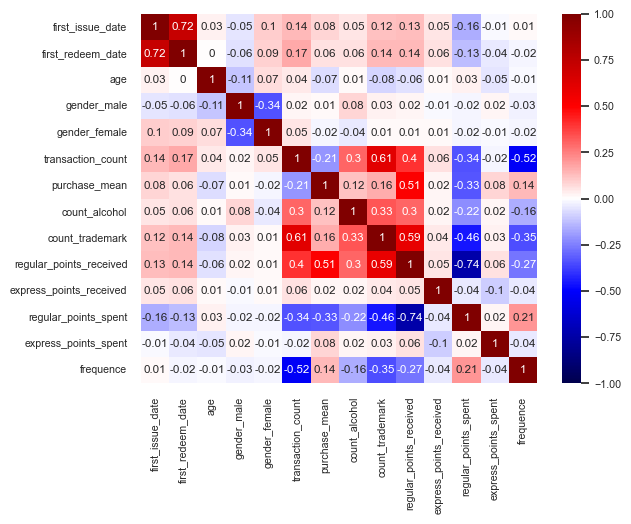

In [42]:
sns.set(font_scale=0.7)
sns.heatmap(df_train.drop(['target', 'treatment_flg'], axis=1).corr().round(2), cmap="seismic", annot=True, vmin=-1, vmax=1)

## Обработка с помощью scikit-uplift (Class Transformation)

In [43]:
df_X = df_train.drop(['treatment_flg', 'target'], axis=1)
df_Y = df_train['target']
df_treatment = df_train['treatment_flg']

Использован классификатор LightGBM. Он был выбран как основанный на деревьях выбора, следовательно, нечуствительный к мультиколлинеарности (межфакторной корреляции)

In [44]:
estimator = LGBMClassifier()
slearner = ClassTransformation(estimator=estimator)

In [45]:
slearner.fit(X=df_X, y=df_Y, treatment=df_treatment)

ClassTransformation(estimator=LGBMClassifier())

In [46]:
uplift_slearner = slearner.predict(df_X)

In [47]:
uplift_at_k_30 = uplift_at_k(y_true=df_Y, uplift=uplift_slearner,
                          treatment=df_treatment,
                          strategy='overall', k=0.3)
qini_coef = qini_auc_score(y_true=df_Y, uplift=uplift_slearner, treatment=df_treatment)
wau = weighted_average_uplift(y_true=df_Y, uplift=uplift_slearner, treatment=df_treatment)
uplift_auc = uplift_auc_score(y_true=df_Y, uplift=uplift_slearner, treatment=df_treatment)
print(uplift_at_k_30, qini_coef, wau, uplift_auc)

0.24759991153728228 0.12965930086671854 0.050522991437498804 0.18574452360618304


**Кривая Qini выпуклая и напоминает колокол, что свидетельствует об адекватном результате**

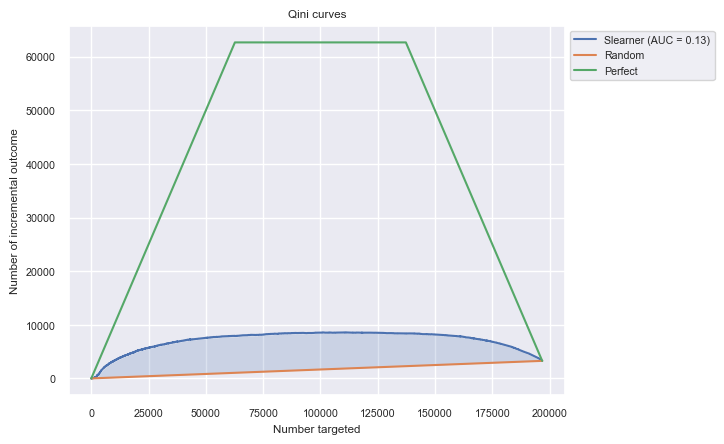

In [48]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Qini curves')

plot_qini_curve(
    df_Y, uplift_slearner, df_treatment, name='Slearner', ax=ax
);

**Uplift-кривая**

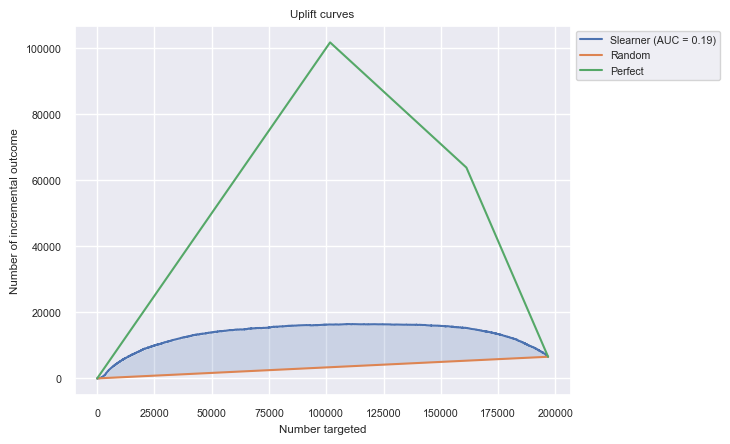

In [49]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Uplift curves')

plot_uplift_curve(
    df_Y, uplift_slearner, df_treatment,
    perfect=True, name='Slearner', ax=ax
);

**Распределение предсказанного uplift на тренировочном датасете**

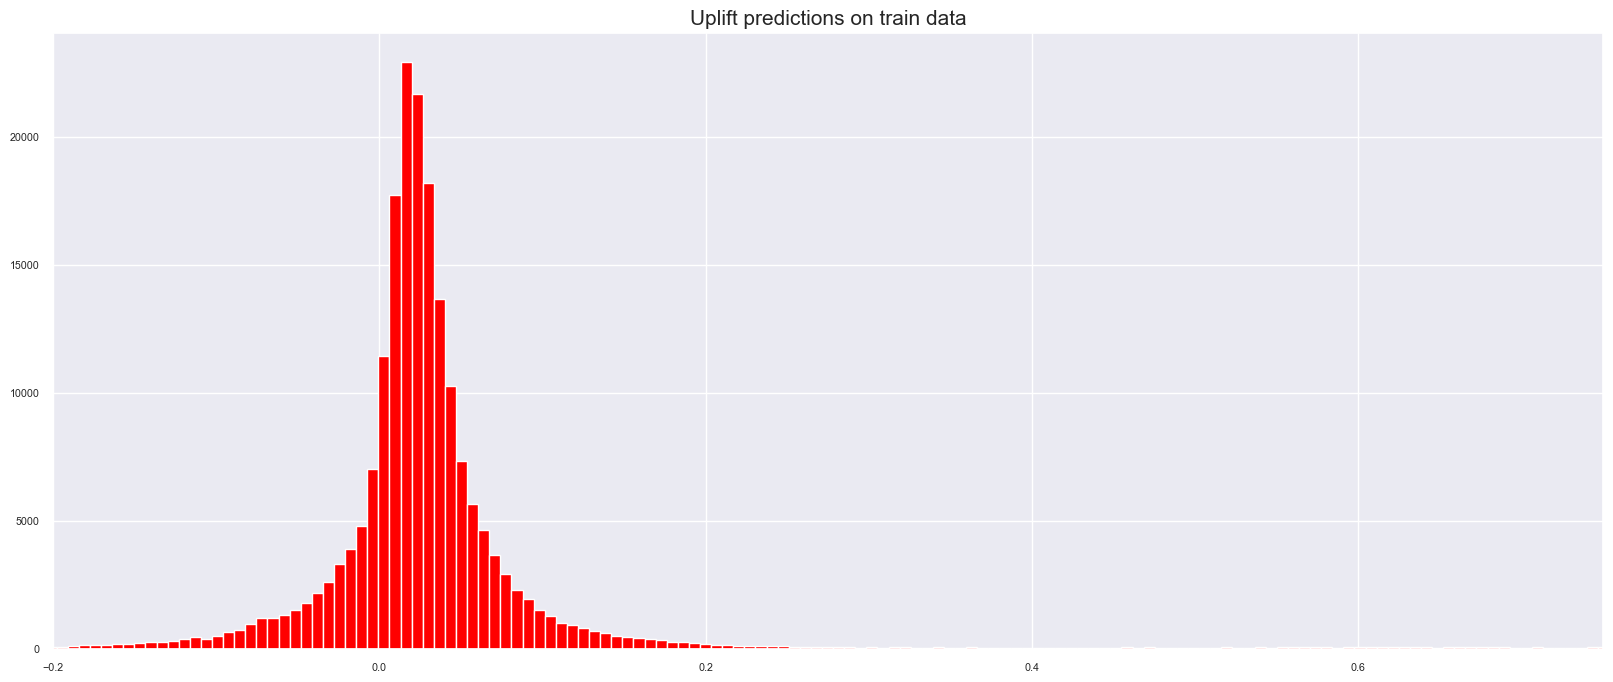

In [50]:
plt.figure(figsize=(20, 8));

plt.hist(
    uplift_slearner,
    bins=200, 
    color='red', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on train data', size=15);

In [51]:
by_percentile = uplift_by_percentile(y_true=df_Y, treatment=df_treatment, uplift=uplift_slearner, strategy='overall')

**Значения показателя uplft по децилям для контрольной и экспериментальной группы**

*Библиотека scikit-uplift предоставляет средства для визуализации подобных показателей, но используемая версия была несовместима с numpy 1.24.3*

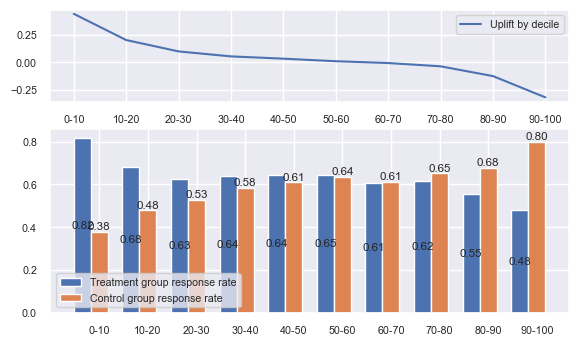

In [52]:
labels = by_percentile.index
x = np.arange(len(labels))
width = 0.35
multiplier = 0
fig, (ax2, ax) = plt.subplots(2, 1, figsize=(17/2.54, 10/2.54), gridspec_kw={'height_ratios': [1, 2]})
rects = ax.bar(x, by_percentile.response_rate_treatment, width, label='Treatment group response rate')
ax.bar_label(rects, label_type='center' , fmt='%.2f')
rects = ax.bar(x + width, by_percentile.response_rate_control, width, label='Control group response rate')
ax.bar_label(rects, fmt='%.2f')

ax.set_xticks(x + width, labels)
ax.legend(loc='lower left')
labels=by_percentile.index
ax2.plot(labels, by_percentile['uplift'], label='Uplift by decile')
ax2.legend(loc='upper right')
plt.show()
plt.show()


**Значимость признаков**

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

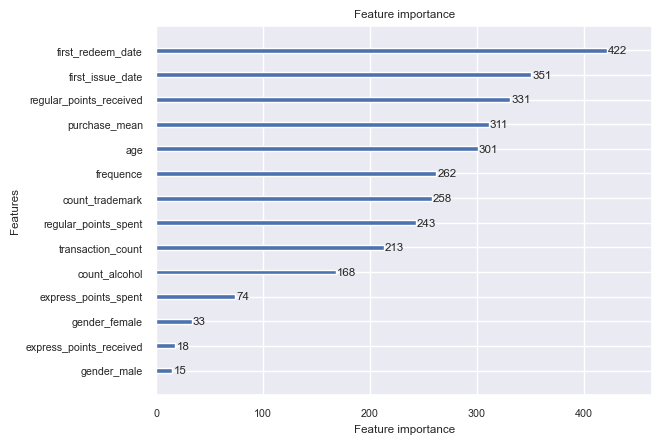

In [53]:
plot_importance(booster=estimator)

## Две зависимые модели

In [54]:
estimator3 = LGBMClassifier()
estimator4 = LGBMClassifier()
tm_ctrl_2 = TwoModels(estimator_trmnt=estimator3, estimator_ctrl=estimator4, method='ddr_control')
tm_ctrl_2.fit(X=df_X, y=df_Y, treatment=df_treatment)

TwoModels(estimator_ctrl=LGBMClassifier(), estimator_trmnt=LGBMClassifier(),
          method='ddr_control')

In [55]:
tm_control_r = tm_ctrl_2.predict(X=df_X)

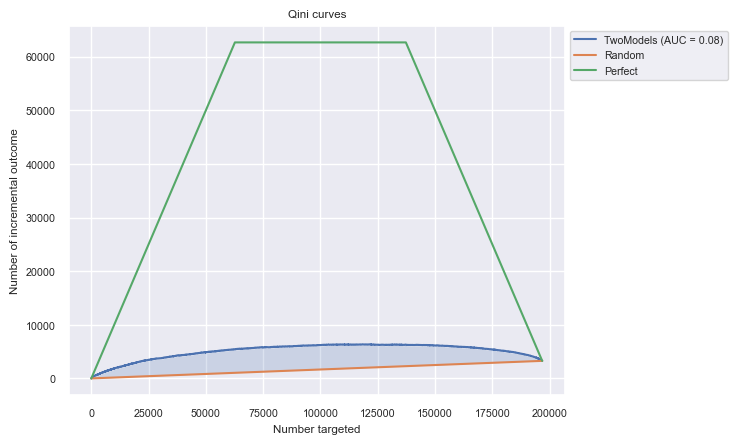

In [56]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Qini curves')

plot_qini_curve(
    df_Y, tm_control_r, df_treatment, name='TwoModels', ax=ax
)

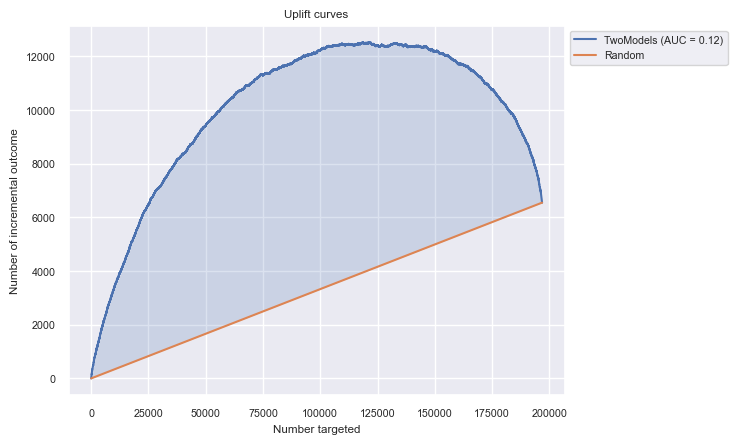

In [57]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Uplift curves')

plot_uplift_curve(
    df_Y, tm_control_r, df_treatment,
    perfect=False, name='TwoModels', ax=ax
);


In [58]:
# Uplift@30%
uplift_at_k_30 = uplift_at_k(y_true=df_Y, uplift=tm_control_r,
                          treatment=df_treatment,
                          strategy='overall', k=0.3)
uplift_at_k_30

0.17375073154927811

In [59]:
by_percentile = uplift_by_percentile(y_true=df_Y, treatment=df_treatment, uplift=tm_control_r, strategy='overall')

In [60]:
by_percentile

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,10638,9043,0.773360,0.494305,0.279055
10-20,9926,9755,0.692525,0.551205,0.141320
20-30,9879,9802,0.692884,0.591920,0.100964
30-40,9833,9847,0.681379,0.619783,0.061596
40-50,9791,9889,0.690634,0.654060,0.036574
50-60,9831,9849,0.686197,0.667885,0.018312
60-70,9693,9987,0.640978,0.645539,-0.004561
70-80,9712,9968,0.581446,0.608949,-0.027503
80-90,9496,10184,0.512953,0.588865,-0.075912


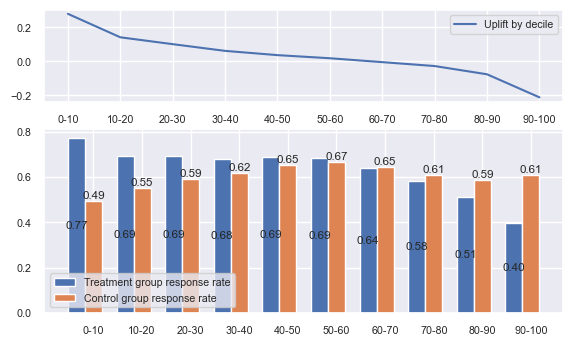

In [61]:
labels = by_percentile.index
x = np.arange(len(labels))
width = 0.35
multiplier = 0
fig, (ax2, ax) = plt.subplots(2, 1, figsize=(17/2.54, 10/2.54), gridspec_kw={'height_ratios': [1, 2]})
rects = ax.bar(x, by_percentile.response_rate_treatment, width, label='Treatment group response rate')
ax.bar_label(rects, label_type='center' , fmt='%.2f')
rects = ax.bar(x + width, by_percentile.response_rate_control, width, label='Control group response rate')
ax.bar_label(rects, fmt='%.2f')

ax.set_xticks(x + width, labels)
ax.legend(loc='lower left')
# ax.invert_xaxis()
labels=by_percentile.index
ax2.plot(labels, by_percentile['uplift'], label='Uplift by decile')
ax2.legend(loc='upper right')
# ax2.invert_xaxis()
plt.show()
plt.show()
#     print(percentile.response_rate_treatment)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

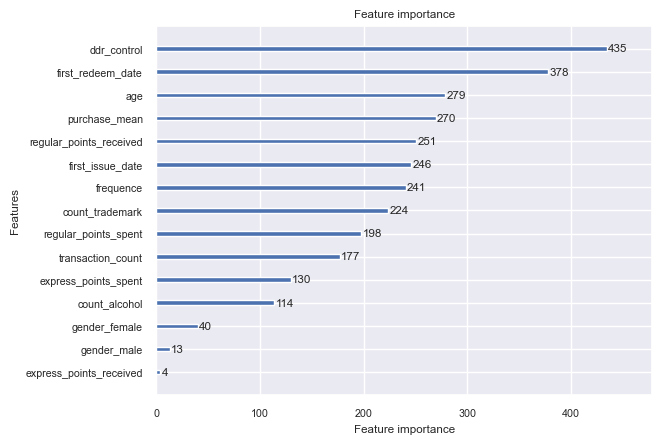

In [62]:
plot_importance(booster=estimator3)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

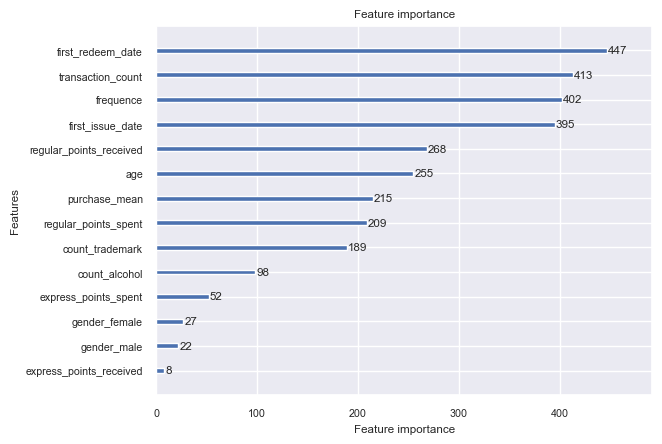

In [63]:
plot_importance(booster=estimator4)

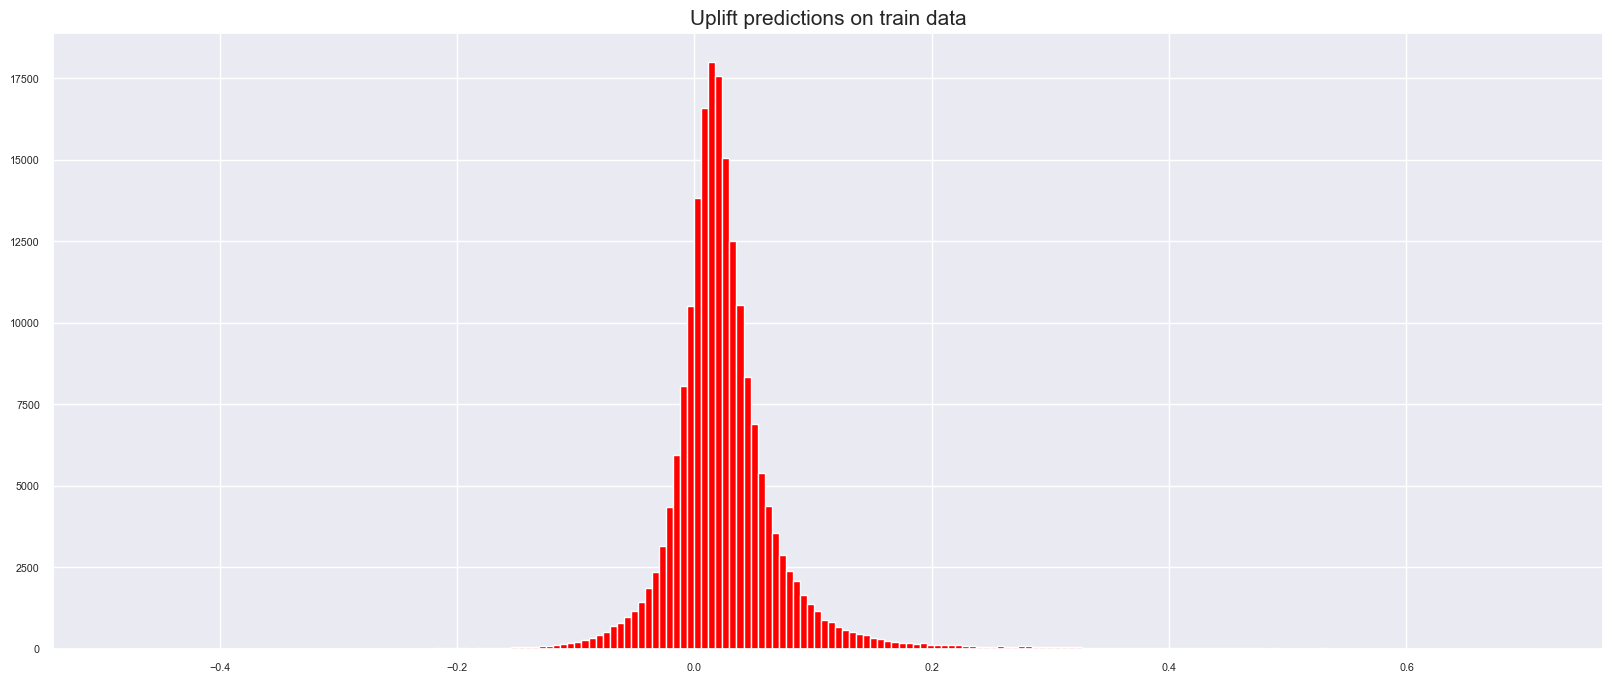

In [64]:
plt.figure(figsize=(20, 8));

plt.hist(
    tm_control_r,
    bins=200, 
    color='red', 
);

# plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on train data', size=15);

# А теперь все то же самое, но на test-датасете с использованием модели преобразования классов

In [65]:
df_test = pd.read_csv('uplift_test.csv', index_col='client_id')

In [66]:
df_test = df_test.merge(df_clients, on='client_id')

In [67]:
df_test

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000048b7a6,2018-12-15 13:33:11,NaT,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U
00007f9014,2017-08-22 13:35:01,2019-02-15 19:19:18,45,F
0000a90cf7,2017-05-20 12:34:50,2017-07-08 12:48:22,45,U
...,...,...,...,...
fffeacbe3e,2017-07-19 08:38:17,2017-10-13 10:59:14,47,F
fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U
ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F


In [68]:
df_test.isna().any()

first_issue_date     False
first_redeem_date     True
age                  False
gender               False
dtype: bool

### Преобразование колонки пола (возможно три текстовых значения) в две колонки с бинарным признаками

In [69]:
df_test['gender_male'] = [1 if i == 'M' else 0 for i in df_test['gender']]
df_test['gender_female'] = [1 if i == 'F' else 0 for i in df_test['gender']]
df_test.drop('gender', axis=1, inplace=True)

### Преобразование колонки даты регистрации в числовые значения

In [70]:
df_test.first_redeem_date.fillna(df_test.first_issue_date, inplace=True)

In [71]:
max_date = max(max(df_test.first_issue_date), max(df_test.first_redeem_date))
df_test['first_issue_date'] = (max_date - df_test['first_issue_date']) // pd.Timedelta('1s')
df_test['first_redeem_date'] = (max_date - df_test['first_redeem_date']) // pd.Timedelta('1s')

### Добавление дополнительных признаков

In [72]:
df_test = df_test.merge(df_purchases.groupby('client_id').nunique()['transaction_id'], on='client_id')
df_test.rename({'transaction_id': 'transaction_count'}, axis=1, inplace=True)

In [73]:
df_test = df_test.merge(df_purchases.groupby(['client_id', 'transaction_id'])['purchase_sum'].mean().groupby('client_id').mean(), on='client_id')
df_test.rename({'purchase_sum': 'purchase_mean'}, axis=1, inplace=True)

In [74]:
df_test = df_test.merge(\
               df_products.reset_index()[['product_id', 'is_alcohol']]\
               .merge(df_purchases.reset_index()[['client_id', 'product_id']], on='product_id')\
               .groupby('client_id')['is_alcohol'].sum(),
               on='client_id')
df_test.rename({'is_alcohol':'count_alcohol'}, axis=1, inplace=True)

In [75]:
df_test = df_test.merge(\
               df_products.reset_index()[['product_id', 'is_own_trademark']]\
               .merge(df_purchases.reset_index()[['client_id', 'product_id']], on='product_id')\
               .groupby('client_id')['is_own_trademark'].sum(),
               on='client_id')
df_test.rename({'is_own_trademark':'count_trademark'}, axis=1, inplace=True)

In [76]:
df_test = df_test.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['regular_points_received']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

In [77]:
df_test = df_test.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['express_points_received']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

In [78]:
df_test = df_test.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['regular_points_spent']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

In [79]:
df_test = df_test.merge(\
                          df_purchases\
                          .groupby(['client_id', 'transaction_id'])['express_points_spent']\
                          .mean()\
                          .groupby('client_id')\
                          .sum(),\
                          on='client_id')

In [80]:
df_test = df_test.merge(\
                          (df_purchases.groupby('client_id')['transaction_datetime'].max()\
                           - df_purchases.groupby('client_id')['transaction_datetime'].min())\
                          // pd.Timedelta('1s'),\
                          on='client_id')
df_test['frequence'] = (df_test['transaction_datetime'] // df_test['transaction_count'])
df_test.drop('transaction_datetime', axis=1, inplace=True)
df_test

,first_issue_date,first_redeem_date,age,gender_male,gender_female,transaction_count,purchase_mean,count_alcohol,count_trademark,regular_points_received,express_points_received,regular_points_spent,express_points_spent,frequence
client_id,,,,,,,,,,,,,,
000048b7a6,29318330,29318330,68,0,1,8,471.500000,0,3,26.5,0.0,0.0,0.0,939563
000073194a,78654947,62676840,60,0,1,17,564.788235,9,3,74.9,0.0,-96.0,0.0,563876
00007c7133,78729293,27922468,67,0,0,11,610.894545,0,10,56.6,0.0,-240.0,0.0,785858
00007f9014,70790220,23940763,45,0,1,29,273.286897,0,4,46.9,0.0,-127.0,0.0,334146
0000a90cf7,78915431,74681019,45,0,0,35,503.297429,2,25,132.6,0.0,-126.0,0.0,276465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,73745624,66306767,47,0,1,12,346.875833,0,33,25.5,0.0,0.0,0.0,756495
fffece623e,47974951,28261522,67,0,0,24,272.083750,1,19,38.4,0.0,-68.0,0.0,400248
ffff3dfff8,33110709,29995094,56,0,1,17,427.343529,2,13,117.9,0.0,-182.0,0.0,569348


In [81]:
uplift_slearner_test = slearner.predict(df_test)

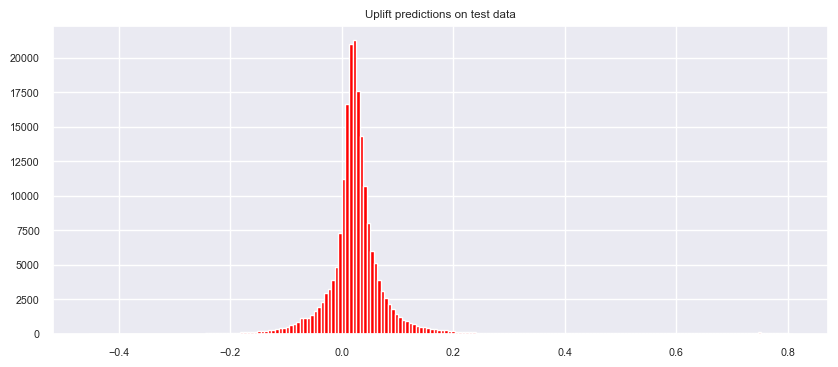

In [82]:
plt.figure(figsize=(10, 4));

plt.hist(
    uplift_slearner_test,
    bins=200, 
    color='red', 
);

# plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on test data');

In [83]:
deciles = np.array_split(sorted(uplift_slearner, reverse=True), 10)
x = list(map(np.average, deciles))

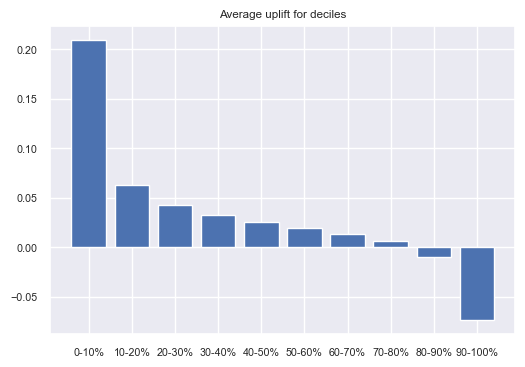

In [84]:
fig, ax = plt.subplots(figsize=(6, 4))
labels=["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
ax.bar(labels, x)
plt.title('Average uplift for deciles');
plt.show()

## Сохранение результатов

In [85]:
df_test_uplift = pd.DataFrame()
df_test_uplift["client_id"] = df_test.index
df_test_uplift['uplift'] = uplift_slearner_test
df_test_uplift.set_index('client_id', inplace=True)
df_test_uplift.to_csv("final_answer.csv")